Importation des bibliothèques nécessaires.

In [1]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from matplotlib import animation

Valeurs numériques pour différents matériaux.

In [2]:
# Largeur du mur
L = 0.5 # (m)

# Conductivité thermique (ordre de grandeur)
lambda_bois = 0.1 # (SI)
lambda_beton = 1 # (SI)
lambda_acier = 10 # (SI)

# Masse volumique (ordre de grandeur)
mu_bois = 800 # (kg/m³)
mu_beton = 2200 # (kg/m³)
mu_acier = 8000 # (kg/m³)

# Capacité thermique massique
c_bois = 2000 # (J/K/kg)
c_beton = 880 # (J/K/kg)
c_acier = 400 # (J/K/kg)

# Coefficient de diffusion
D_bois = lambda_bois / (mu_bois * c_bois) # (m²/s)
D_beton = lambda_beton / (mu_beton * c_beton) # (m²/s)
D_acier = lambda_acier / (mu_acier * c_acier) # (m²/s)

# Temps caractéristique de diffusion (défini par analyse dimensionnelle)
tau_diffusion_bois = L**2 / D_bois # (s)
tau_diffusion_beton = L**2 / D_beton # (s)
tau_diffusion_acier = L**2 / D_acier # (s)

# Température du thermostat extérieur
T0 = 268. # (K)
# Température initiale de l'intérieur de la pièce
Tint_0 = 293. # (K)

Introduction de la durée typique `tau` d'évolution de la température `Tint` de l'intérieur de la pièce. Pour simplifier, on modélise la température de l'intérieur comme une fonction affine du temps. 

In [16]:
tau_diffusion = tau_diffusion_bois
tau = 10 * tau_diffusion

D = D_bois
Lambda = lambda_bois

def Tint(t):
    if T0 + (Tint_0 - T0) * (1 - t / tau) < T0:
        return T0
    else:
        return T0 + (Tint_0 - T0) * (1 - t / tau)

Paramètres de la résolution numérique.

In [17]:
# Discrétisation spatiale du mur (nombre de points)
Nx = 100

# Abscisses où l'on détermine numériquement la température
X = np.linspace(0., L, Nx, endpoint = True)

# Discrétisation du pas spatial
pas_spatial = L / Nx # (m)

Définition de l'équation différentielle. 

Ici, c'est un peu subtil (et hors programme). En effet, l'équation de diffusion est une équation aux dérivées partielles (EDP) : $\frac{\partial T}{\partial t} = D \frac{\partial^2 T}{\partial x^2}$. `odeint` est un solveur d'équations différentielles ordinaires. On va donc discrétiser explicitement la partie spatiale de l'EDP et condidérer chaque approximation spatiale du champ de température comme un fonction à une seule variable (de la date $t$). Ainsi, on pourra utiliser `odeint` pour résoudre par rapport à $t$.

Tu peux te reporter à l'[épreuve de modélisation de CC(IN)P, filère PC, 2015](http://www.concours-commun-inp.fr/_resources/annales%2520%25C3%25A9crits/PC/2015/PC-Modelisation.pdf?download=true).

In [18]:
def EDP(T, t):
    dTdt = np.zeros(X.shape)

    # On traite les bords du domaine.
    # On fait l'hypothèse du contact thermique parfait.
    dTdt[0] = D * (T[1] - 2 * T[0] + T0) / pas_spatial**2
    dTdt[-1] = D * (T[-2] - 2 * T[-1] + Tint(t)) / pas_spatial**2

    # On discrétise l'équation de la chaleur
    dTdt[1:-1] = D * (T[2:] - 2*T[1:-1] + T[0:-2]) / pas_spatial**2

    return dTdt


# Conditions initiales en tout point du mur
Tmur0 = (Tint_0 - T0) * X / L + T0

# Dates des instants où la température est déterminée de manière approchée
tmax = max(tau, tau_diffusion) # (s)
Nt = 1000

t = np.linspace(0., tmax, Nt, endpoint = True)

# On résout l'équation différentielle ordinaire (Nx fonctions de la seule variable t)
sol = odeint(EDP, Tmur0, t)

Obtention du vecteur densité de courant thermique $j_Q = - \lambda \frac{\partial T}{\partial x}$ par discrétisation de la dérivée partielle par rapport à $x$. On ne peut donc pas obtenir les valeurs en $x = 0$ et en $x = L$ par cette méthode. On applique alors la continuité de $j_Q$.

In [19]:
jQ = np.zeros(sol.shape)

# Loi de Fourier
jQ[:,1:-1] = - Lambda * (sol[:,1:-1] - sol[:,0:-2]) / pas_spatial

# Continuité du flux thermique aux bords
jQ[:,0] = jQ[:,1]
jQ[:,-1] = jQ[:,-2]

<IPython.core.display.Javascript object>


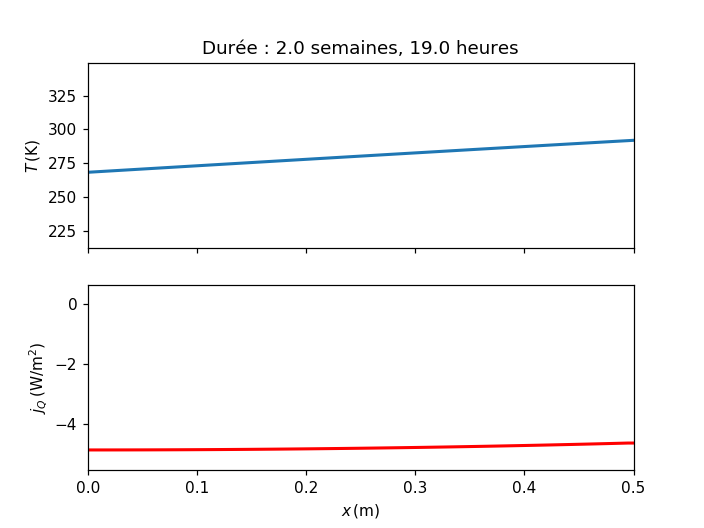

In [20]:
intervals = (
    ('semaines', 604800),  # 60 * 60 * 24 * 7
    ('jours', 86400),    # 60 * 60 * 24
    ('heures', 3600),    # 60 * 60
    ('minutes', 60),
    ('secondes', 1),
    )

def display_time(seconds, granularity = 2):
    result = []

    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

fig1, (ax1, ax2) = plt.subplots(2, 1, sharex = True)

ax1.set_xlim(0, L)
ax1.set_ylim(np.min([T0, Tint_0]) - ((T0 + Tint_0) / 10), np.max([T0, Tint_0]) + ((T0 + Tint_0) / 10))

line1, = ax1.plot([], [], lw=2)

ax1.set_ylabel(r'$T\,(\mathrm{K})$')

ax2.set_xlim(0, L)
ax2.set_ylim(np.min(jQ) - abs(((np.min(jQ) + np.max(jQ)) / 10)), np.max(jQ) + abs(((np.min(jQ) + np.max(jQ)) / 10)))

line2, = ax2.plot([], [], 'r', lw=2)

ax2.set_xlabel(r'$x\,(\mathrm{m})$')
ax2.set_ylabel(r'$j_Q\,(\mathrm{W/m^2})$')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,

def animate(i):
    line1.set_data(X, sol[i, :])
    line2.set_data(X, jQ[i, :])
    ax1.set_title("Durée : " + str(display_time(t[i])))
    return line1, line2,

anim = animation.FuncAnimation(fig1, animate, init_func = init,
                               frames = len(t), interval = 5, blit = True)

On constate que lorsque $\tau \gg \tau_{\text{diffusion}}$, le vecteur densité de courant thermique $j_Q$ est quasi uniforme et le profil de température est quasi affine. Dans ces conditions, le conditions de l'ARQS sont vérifiées. On peut alors étendre la notion de résistance thermique et la loi d'Ohm thermique, y compris en régime non stationnaire.

En revanche, lorsque $\tau \ll \tau_{\text{diffusion}}$, le vecteur densité de courant thermique $j_Q$ n'est pas uniforme et le profil de température n'est quasi affine. Dans ces conditions, le conditions de l'ARQS ne sont pas vérifiées. La notion de résistance thermique et la loi d'Ohm thermique ne sont alors applicables qu'une fois que le régime stationnaire est atteint.